In [ ]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
api_token = {"username":"use_your_username","key":"use_your_api_key"}

In [ ]:
import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

imdb-dataset-of-50k-movie-reviews.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip imdb-dataset-of-50k-movie-reviews.zip

Archive:  imdb-dataset-of-50k-movie-reviews.zip
replace IMDB Dataset.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: IMDB Dataset.csv        


In [ ]:
!ls

'IMDB Dataset.csv'   imdb-dataset-of-50k-movie-reviews.zip   sample_data


## Question 1: Import Libraries/Dataset 

In [ ]:
%tensorflow_version 2.x

In [ ]:
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import seaborn as sns
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from bs4 import BeautifulSoup
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import LancasterStemmer,WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

#### GPU is Available

In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
df = pd.read_csv("IMDB Dataset.csv")
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
df.sentiment.value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

## Question 2 : Data Visualization

#### 1. Print at least two movie reviews from each class of the dataset, for a sanity check that labels match the text.

In [ ]:
print(df[df.sentiment=='positive']['review'].values[:2])

["One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the f

In [ ]:
print(df[df.sentiment=='negative']['review'].values[:2])

["Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless thriller spots.<br /><br />3 out of 10 just for the well playing parents & descent dialogs. As for the shots with Jake: just ignore them."
 "This show was an amazing, fresh & innovative idea in the 70's when it first aired. The first 7 or 8 years were brilliant, but things dropped off after that. By 1990, the show was not really funny anymore, and it's continued its decline further to

#### 2. Plot a bar graph of class distribution in a dataset. Each bar depicts the number of tweets belonging to a particular sentiment.

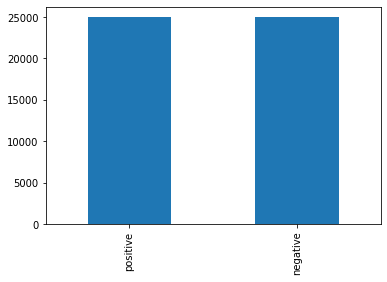

In [ ]:
df.sentiment.value_counts().plot(kind='bar')

Splitting in train and test data and checking shape

In [ ]:
X, y = df.review, df.sentiment
X.shape, y.shape

((50000,), (50000,))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,)


In [ ]:
X_train.shape, X_test.shape

((37500,), (12500,))

In [ ]:
print(y_train.value_counts()) 
print(y_test.value_counts())

negative    18776
positive    18724
Name: sentiment, dtype: int64
positive    6276
negative    6224
Name: sentiment, dtype: int64


## Question 3 : Data Pre-processing

#### 1. Text Pre-Processing

In [ ]:
#HTML Parsing to Text
def process_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()
  
#Removing the square brackets
def remove_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

#Removing special characters
def remove_special_characters(text):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,' ',text)
    text = text.strip()
    return text

# Text Lemmatization
lemmatizer = WordNetLemmatizer()
def simple_lemma(text):
    text= ' '.join([lemmatizer.lemmatize(word) for word in text.split()])
    return text

#removing the stopwords
tokenizer=ToktokTokenizer()
stopword_list=nltk.corpus.stopwords.words('english')
def remove_stopwords(text):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text    

def pre_process_text(text):
    text = process_html(text)
    text = remove_brackets(text)
    text = remove_stopwords(text)
    text = remove_special_characters(text)
    text = simple_lemma(text)
    
    return text

In [ ]:
%%time
X_train = X_train.apply(pre_process_text)
X_test = X_test.apply(pre_process_text)

CPU times: user 1min 29s, sys: 470 ms, total: 1min 30s
Wall time: 1min 30s


In [ ]:
# X_train = tf.convert_to_tensor(X_train)
# X_test = tf.convert_to_tensor(X_test)

In [ ]:
y_train = y_train.map({'positive': 1, 'negative':0})
y_test = y_test.map({'positive': 1, 'negative':0})

# y_train = tf.convert_to_tensor(y_train)
# y_test = tf.convert_to_tensor(y_test)


#### 2. Using Pre-trained layer and bring test and train data in required format

In [ ]:

model = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(model, input_shape=[], dtype=tf.string, trainable=True)
# X_train = hub_layer(X_train)
# X_test = hub_layer(X_test)

## Question 4: Model Building 

Sequential Model layers

Use AT LEAST 3 hidden layers with appropriate input for each

Add L2 regularization to all the layers.


Add one layer of dropout at the appropriate position and give reasons.


Choose the appropriate activation function for all the layers.


Print the model summary.


In [ ]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(shape=(), name="Input", dtype=tf.string))
model.add(hub_layer)
model.add(tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.1)))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.1)))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# model.add(hub_layer)
# model.add(tf.keras.layers.Dense(16, activation='relu'))
# model.add(tf.keras.layers.Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 50)                48190600  
_________________________________________________________________
dense (Dense)                (None, 32)                1632      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 48,192,777
Trainable params: 48,192,777
Non-trainable params: 0
_________________________________________________________________


Reason for choosing Hidden units:

There are many rule-of-thumb methods for determining the correct number of neurons to use in the hidden layers, such as the following:

1. The number of hidden neurons should be between the size of the input layer and the size of the output layer.<br>
2. <b>The number of hidden neurons should be 2/3 the size of the input layer, plus the size of the output layer.</b><br>
3. The number of hidden neurons should be less than twice the size of the input layer.

Using these 3 formulas.<br> 
Getting values ~ 32 and 16 for the 2 hidden layers.

Reason for putting dropout just after the pre-trained vector.

<b>Usually, dropout is placed on the fully connected layers only because they are the one with the greater number of parameters and thus they're likely to excessively co-adapting themselves causing overfitting</b>

Choice of Activation functions:

<b> We have used relu, in all the hidden layers because rectified linear activation function overcomes the vanishing gradient problem, allowing models to learn faster and perform better.

In the output layer, we want binary output (0 or 1) so we have used sigmoid.

## 5. Model Compilation

Compile the model with the appropriate loss function

Use an appropriate optimizer. Give reasons for the choice of learning rate and its value.

Use accuracy as a metric.


In [ ]:
model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])  
              # metrics=[tf.metrics.BinaryAccuracy(threshold=0.0, name='accuracy')])  

We are choosing Adam Optimizer.

Adam is a replacement optimization algorithm for stochastic gradient descent for training deep learning models. Adam combines the best properties of the AdaGrad and RMSProp algorithms to provide an optimization algorithm that can handle sparse gradients on noisy problems. <b> This algorithm is used to accelerate the gradient descent algorithm by taking into consideration the 'exponentially weighted average' of the gradients. Using averages makes the algorithm converge towards the minima in a faster pace </b>

<br>

<b>Adam is and adaptive optimizer, and it learns the learning rates itself, on a per-parameter basis. So we are not specifying learning rate

## 6. Model Training

Train the model for an appropriate number of epochs. Print the train and validation
accuracy and loss for each epoch. Use the appropriate batch size.


Plot the loss and accuracy history graphs for both train and validation set. Print the total
time taken for training.


In [ ]:
# Creating validation set

X_validation_ = X_train[:5000]
X_train_ = X_train[5000:]

y_validation_ = y_train[:5000]
y_train_ = y_train[5000:]


X_train_.shape, X_validation_.shape, y_train_.shape, y_validation_.shape

((32500,), (5000,), (32500,), (5000,))

In [ ]:
X_train_[:1]

46808    made mistake buying since collect comic book i...
Name: review, dtype: object

In [ ]:
history = model.fit(X_train_,
                    y_train_,
                    epochs=25,
                    batch_size=256,
                    validation_data=(X_validation_, y_validation_),
                    verbose=1)

Epoch 1/25
127/127 [==============================] - 9s 60ms/step - loss: 5.2852 - accuracy: 0.5740 - val_loss: 2.1381 - val_accuracy: 0.8220
Epoch 2/25
127/127 [==============================] - 7s 55ms/step - loss: 1.7044 - accuracy: 0.8059 - val_loss: 0.8392 - val_accuracy: 0.8800
Epoch 3/25
127/127 [==============================] - 7s 56ms/step - loss: 0.7244 - accuracy: 0.8817 - val_loss: 0.5081 - val_accuracy: 0.8938
Epoch 4/25
127/127 [==============================] - 7s 56ms/step - loss: 0.4541 - accuracy: 0.9141 - val_loss: 0.4173 - val_accuracy: 0.8996
Epoch 5/25
127/127 [==============================] - 7s 56ms/step - loss: 0.3597 - accuracy: 0.9344 - val_loss: 0.3852 - val_accuracy: 0.8990
Epoch 6/25
127/127 [==============================] - 7s 56ms/step - loss: 0.3127 - accuracy: 0.9463 - val_loss: 0.3652 - val_accuracy: 0.9028
Epoch 7/25
127/127 [==============================] - 7s 57ms/step - loss: 0.2849 - accuracy: 0.9544 - val_loss: 0.3545 - val_accuracy: 0.9024

Used the formula to find the ~ batch size to be used.

batch size= available GPU memory bytes / (size of tensors + trainable parameters)

Considering GPU memory = 12GB = 12\*1024\*1024\*1024

trainable parameters = 48,192,777

So, batch size ~ 270, so choosed 256.

In [ ]:
# Plot the loss and accuracy history graphs for both train and validation set. Print the total
# time taken for training.

history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

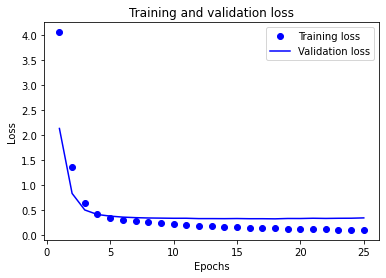

In [ ]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

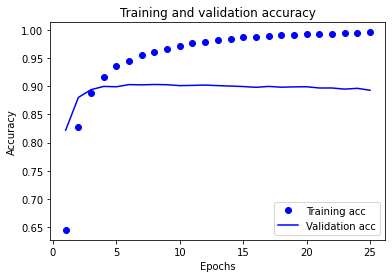

In [ ]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 7. Model Evaluation

Print the final train and validation loss and accuracy. Print confusion matrix and
classification report for the validation dataset. Analyse and report the best and worst
performing class.

In [ ]:
results = model.evaluate(X_test, y_test)

print(results)

391/391 [==============================] - 2s 5ms/step - loss: 0.3467 - accuracy: 0.8952
[0.3466631770133972, 0.8952000141143799]


In [ ]:
y_pred = (model.predict(X_test) > 0.5).astype("int32")
y_pred_prob = model.predict(X_test)

In [ ]:
y_pred[:5]

array([[1],
       [1],
       [0],
       [0],
       [1]], dtype=int32)

In [ ]:
confusion = tf.math.confusion_matrix(labels=y_test, predictions=y_pred)
confusion

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[5637,  587],
       [ 723, 5553]], dtype=int32)>

In [ ]:
from sklearn.metrics import classification_report
import time
import numpy as np
start_time = time.time()
test_predictions = (model.predict(X_test) > 0.5).astype("int32")
# Comparing the predictions to actual forest cover types for the test rows
# test is the data right after splitting into train, test and val (shuffle was false in dataset so the order will match)
print(classification_report(y_test,test_predictions))
print("Time taken to predict the model " + str(time.time() - start_time))

              precision    recall  f1-score   support

           0       0.89      0.91      0.90      6224
           1       0.90      0.88      0.89      6276

    accuracy                           0.90     12500
   macro avg       0.90      0.90      0.90     12500
weighted avg       0.90      0.90      0.90     12500

Time taken to predict the model 1.2555584907531738


In [ ]:
# Compute most errorenous predictions

In [ ]:
res = []
for i,j,k  in zip(X_test, y_test, y_pred_prob):
    res.append([i, j-k])
    

In [ ]:
def takeSecond(elem):
    return elem[1]
res.sort(key=takeSecond)

In [ ]:
# Most errorenous positive predictions
res[:2]

[['saw bit film interested see full thing see critic give two star result agree Basically film begin Kermit Frog Steve Whitmire telling Muppet chum lost everything end sitting depressed possibly thinking suicide bench Meanwhile another world Heaven angel Daniel David Arquette already Muppets Space visit Boss Whoopi Goldberg another reason wanted see film show Kermit really need help flashback show Kermit Miss Piggy Eric Jacobson original better Frank Oz Gonzo Dave Goelz Fozzie Bear also Jacobson Pepe Prawn Bill Barretta Muppets prepared stage show many people see Christmas holiday seems going well really mean Rachel Bitterman Joan Cusack determined either shut show theatre Kermit everything possible make sure happen course Kermit fails last time Bitterman tell finished officially take theatre Daniel sent Kermit guardian angel try help Kermit mood eventually end saying wish never born Obviously recognise spoof Wonderful Life Kermit George Bailey Cusack Mr Potter end obviously Kermit rea

In [ ]:
# Most errorenous negative predictions
res[-2:]

[['hilariously horrible 70 made for TV horror clinker deadly demonically possessed dessert cake Still exceptionally awful yet undeniably amusing thus enjoyable cathode ray refuse reach breathtaking apex absolute unremitting silliness atrociousness quite tasty so execrable it s downright awesome sort way Richard Crenna looking haggard possibly inebriated Yvette Mimieux act never got brutal rape endured Jackson County Jail sluggishly portray disgustingly nice respectable suburbanite couple whose quaint dull sleepy small town existence get ripped asunder cute German Shepard take family pet turn ancient lethal evil spirit Pretty soon Mimieux two repellently cutesy kid Kim Richards Ike Eisenmann psychic alien moppet Disney Witch Mountain picture worshiping crude crayon drawing nasty ugly canine entity den Boy sound really scary disturbing Well scary disturbing laughably ludicrous claptrap sure sure funny thanks Curtis Night Tide Harrington hopelessly weak direction cartoonish special effect

## Modified Model 1

In [ ]:
import gc
tf.keras.backend.clear_session()
gc.collect()

7398

In [ ]:
# Dropout: Change the position and value of dropout layer

model1 = tf.keras.Sequential()
model1.add(tf.keras.layers.Input(shape=(), name="Input", dtype=tf.string))
model1.add(hub_layer)
model1.add(tf.keras.layers.Dropout(0.50))
model1.add(tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.1)))
model1.add(tf.keras.layers.Dropout(0.50))
model1.add(tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.1)))
model1.add(tf.keras.layers.Dropout(0.20))
model1.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# model.add(hub_layer)
# model.add(tf.keras.layers.Dense(16, activation='relu'))
# model.add(tf.keras.layers.Dense(1))

model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 50)                48190600  
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                1632      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1

In [ ]:
model1.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])  
              # metrics=[tf.metrics.BinaryAccuracy(threshold=0.0, name='accuracy')])  

In [ ]:
history = model1.fit(X_train_,
                    y_train_,
                    epochs=25,
                    batch_size=256,
                    validation_data=(X_validation_, y_validation_),
                    verbose=1)

Epoch 1/25
127/127 [==============================] - 8s 59ms/step - loss: 5.2612 - accuracy: 0.6348 - val_loss: 2.0119 - val_accuracy: 0.8970
Epoch 2/25
127/127 [==============================] - 7s 56ms/step - loss: 1.5215 - accuracy: 0.9547 - val_loss: 0.7483 - val_accuracy: 0.8980
Epoch 3/25
127/127 [==============================] - 7s 56ms/step - loss: 0.5497 - accuracy: 0.9744 - val_loss: 0.4553 - val_accuracy: 0.8984
Epoch 4/25
127/127 [==============================] - 7s 56ms/step - loss: 0.3099 - accuracy: 0.9816 - val_loss: 0.3881 - val_accuracy: 0.8988
Epoch 5/25
127/127 [==============================] - 7s 56ms/step - loss: 0.2463 - accuracy: 0.9823 - val_loss: 0.3687 - val_accuracy: 0.8998
Epoch 6/25
127/127 [==============================] - 7s 57ms/step - loss: 0.2192 - accuracy: 0.9827 - val_loss: 0.3604 - val_accuracy: 0.8984
Epoch 7/25
127/127 [==============================] - 7s 56ms/step - loss: 0.2018 - accuracy: 0.9844 - val_loss: 0.3560 - val_accuracy: 0.8988

In [ ]:
results = model.evaluate(X_test, y_test)

print(results)

391/391 [==============================] - 2s 5ms/step - loss: 0.4013 - accuracy: 0.8958
[0.40125319361686707, 0.8958399891853333]


## Modified Model 2

In [ ]:
tf.keras.backend.clear_session()
gc.collect()

2472

In [ ]:
# Dropout: Change the Batch Size

model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(shape=(), name="Input", dtype=tf.string))
model.add(hub_layer)
model.add(tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.1)))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.1)))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# model.add(hub_layer)
# model.add(tf.keras.layers.Dense(16, activation='relu'))
# model.add(tf.keras.layers.Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 50)                48190600  
_________________________________________________________________
dense (Dense)                (None, 32)                1632      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 48,192,777
Trainable params: 48,192,777
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])  
              # metrics=[tf.metrics.BinaryAccuracy(threshold=0.0, name='accuracy')])  

In [ ]:
history = model.fit(X_train_,
                    y_train_,
                    epochs=25,
                    batch_size=512,
                    validation_data=(X_validation_, y_validation_),
                    verbose=1)

Epoch 1/25
64/64 [==============================] - 5s 68ms/step - loss: 5.7799 - accuracy: 0.8173 - val_loss: 3.5591 - val_accuracy: 0.8966
Epoch 2/25
64/64 [==============================] - 4s 63ms/step - loss: 2.9904 - accuracy: 0.9828 - val_loss: 1.9379 - val_accuracy: 0.8964
Epoch 3/25
64/64 [==============================] - 4s 63ms/step - loss: 1.5791 - accuracy: 0.9877 - val_loss: 1.1158 - val_accuracy: 0.8956
Epoch 4/25
64/64 [==============================] - 4s 63ms/step - loss: 0.8579 - accuracy: 0.9918 - val_loss: 0.7073 - val_accuracy: 0.8966
Epoch 5/25
64/64 [==============================] - 4s 64ms/step - loss: 0.4946 - accuracy: 0.9938 - val_loss: 0.5114 - val_accuracy: 0.8960
Epoch 6/25
64/64 [==============================] - 4s 64ms/step - loss: 0.3174 - accuracy: 0.9943 - val_loss: 0.4214 - val_accuracy: 0.8974
Epoch 7/25
64/64 [==============================] - 4s 64ms/step - loss: 0.2324 - accuracy: 0.9943 - val_loss: 0.3817 - val_accuracy: 0.8966
Epoch 8/25
64

In [ ]:
results = model.evaluate(X_test, y_test)

print(results)

391/391 [==============================] - 2s 5ms/step - loss: 0.3503 - accuracy: 0.8959
[0.35034340620040894, 0.8959199786186218]


Comparision of 3 models

1. Base Model: 

  --->Training set : loss: 0.1088 - accuracy: 0.9960 <br>
  --->Test Set: loss: 0.3467 - accuracy: 0.8952

<br><br>
2. Model 1: loss:

  --->Training set : loss: 0.1030 - accuracy: 0.9937 <br>(loss is less and accuracy is less on training and more on test data. (so less overfitted model) <br>
  --->Test Set: loss: 0.4013 - accuracy: 0.8958

<br><br>
3. Model 2:

  --->Training set : loss: 0.1014 - accuracy: 0.9966 <br>(loss is less and accuracy is more on training and more on test data. (so better model) <br>
  --->Test Set: loss: 0.3503 - accuracy: 0.8959